# Data Modeling

**Goal:** Train, evaluate, tune, and select the best machine learning model to predict the log-transformed price (`log_price`) of Prague Airbnb listings as accurately as possible, based on the prepared dataset.

## 1. Setup and Baselines
*   Import necessary libraries for modeling and evaluation.
*   Load the processed and scaled training/testing data splits.
*   Load the saved scaler and feature list.
*   Define evaluation metrics and a helper function for reporting on the original price scale.
*   Establish baseline performance metrics (mean prediction and simple Linear Regression).

### Import Libraries
Import libraries for data handling, modeling algorithms, evaluation metrics, cross-validation, and loading saved objects.

In [1]:
# Data Handling
import pandas as pd
import numpy as np
import joblib # For loading scaler/feature list

# Modeling Algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor # For mean baseline

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cross-validation and Tuning
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV 
# from sklearn.model_selection import GridSearchCV # Alternative tuner

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x) # More precision for metrics

print("Libraries imported for modeling.")

Libraries imported for modeling.


### Load Processed Data and Preprocessors
Load the scaled training and testing datasets (`X_train_scaled`, `X_test_scaled`, `y_train`, `y_test`) saved at the end of Data Preparation. Also load the fitted `StandardScaler` and the final feature list.

In [2]:
# Define paths (relative to notebooks/ directory)
data_path = '../data/processed/'
model_path = '../model/'

try:
    # Load features and target
    X_train_scaled = pd.read_parquet(data_path + 'X_train_scaled.parquet')
    X_test_scaled = pd.read_parquet(data_path + 'X_test_scaled.parquet')
    y_train = pd.read_parquet(data_path + 'y_train.parquet')['log_price'] # Extract Series
    y_test = pd.read_parquet(data_path + 'y_test.parquet')['log_price'] # Extract Series
    
    # Load preprocessors
    scaler = joblib.load(model_path + 'standard_scaler.joblib')
    final_features = joblib.load(model_path + 'final_feature_list.joblib')

    print("Processed data and preprocessors loaded successfully.")
    
    # Verify shapes and columns
    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"X_test_scaled shape : {X_test_scaled.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape : {y_test.shape}")
    
    # Check if columns match saved list
    if list(X_train_scaled.columns) == final_features:
        print("\nTrain data columns match the saved feature list.")
    else:
        print("\nWarning: Train data columns mismatch saved feature list!")
        
    # Display head of loaded data
    print("\nHead of X_train_scaled:")
    display(X_train_scaled.head(3))
    print("\nHead of y_train:")
    display(y_train.head(3))
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure preprocessing steps were run and files saved correctly.")
    # Set variables to None to prevent errors in subsequent cells
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, final_features = [None]*6
except Exception as e:
    print(f"An error occurred during loading: {e}")
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, final_features = [None]*6

Processed data and preprocessors loaded successfully.
X_train_scaled shape: (7014, 66)
X_test_scaled shape : (1754, 66)
y_train shape: (7014,)
y_test shape : (1754,)

Train data columns match the saved feature list.

Head of X_train_scaled:


,host_acceptance_rate,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,num_amenities,amenity_wifi,amenity_kitchen,amenity_air_conditioning,amenity_heating,amenity_washer,amenity_dryer,amenity_tv,amenity_parking,amenity_pool,amenity_pets_allowed,amenity_long_term_stays_allowed,num_host_verifications,host_duration_days,days_since_last_review,has_reviews,calculated_host_listings_count_shared_rooms_log,bathrooms_log,calculated_host_listings_count_private_rooms_log,host_acceptance_rate_log,beds_log,days_since_last_review_log,number_of_reviews_log,bedrooms_log,reviews_per_month_log,accommodates_log,calculated_host_listings_count_entire_homes_log,number_of_reviews_ltm_log,host_response_time_Unknown,host_response_time_days_or_more,host_response_time_within_day,host_response_time_within_hour,host_response_time_within_hours,room_type_Entire_home/apt,room_type_Hotel_room,room_type_Private_room,room_type_Shared_room,neighbourhood_group_Near_Center_East,neighbourhood_group_Near_Center_West_South,neighbourhood_group_New_Town_Vinohrady,neighbourhood_group_North_West_Districts,neighbourhood_group_Old_Town_Center,neighbourhood_group_Outer_Districts,property_type_freq
7040,0.31773,0.12796,-1.00211,-0.14625,-0.43309,-0.39264,-0.39836,-0.23443,0.11789,-0.34667,-0.92162,-0.38376,-0.39253,0.41020,0.70862,0.67324,0.62997,-1.27978,-0.34365,-0.28196,-0.09380,0.10470,0.76782,0.11142,0.27675,0.49447,0.27406,0.47563,0.33138,0.57922,0.83073,-0.15181,-0.63003,0.84602,2.14201,1.30126,-0.34586,0.30193,-0.11009,-0.47959,-0.45942,0.30163,-0.07051,-0.68492,0.16380,-0.29696,0.42263,-0.33622,0.17524,0.79439,-0.25524,-0.12387,-0.21395,0.46501,-0.24755,0.42475,-0.09210,-0.39484,-0.09821,-0.50049,-0.31222,2.14633,-0.28823,-0.76678,-0.30585,0.80065
7863,0.37241,0.12796,0.22597,-0.05502,0.73766,-0.39264,-0.39836,0.21767,-0.34522,-1.18489,-1.24191,-1.46549,-0.22562,1.27716,0.57742,0.79933,0.62997,0.78139,-0.60287,-0.28196,-0.09380,1.62976,0.84291,0.11142,0.27675,-2.02237,0.27406,0.47563,0.33138,0.57922,0.83073,-0.15181,-0.63003,0.84602,-0.13436,-1.61776,-0.35023,0.30193,-0.11009,-0.47959,-0.45942,0.34406,0.54130,-1.45500,0.41736,-0.29696,1.46903,0.96261,-0.65080,1.13384,-0.25524,-0.12387,-0.21395,0.46501,-0.24755,0.42475,-0.09210,-0.39484,-0.09821,-0.50049,-0.31222,-0.46591,-0.28823,1.30415,-0.30585,-1.17634
7652,0.31773,0.12796,-0.37276,-0.70000,1.90841,1.84332,1.78027,1.12185,0.11789,-0.34667,-0.60133,-0.11105,-0.67626,-0.85084,0.80701,-3.40372,-2.29712,-1.27978,0.00199,-0.28196,-0.09380,-0.96671,0.39238,0.11142,0.27675,0.49447,0.27406,0.47563,0.33138,0.57922,0.83073,-0.15181,1.58724,0.84602,-0.13436,1.11990,-0.23744,0.30193,-0.11009,2.25335,-0.45942,0.30163,1.40360,0.76876,-1.49494,1.67274,-1.30581,1.79043,0.65344,-1.13301,-0.25524,-0.12387,-0.21395,0.46501,-0.24755,0.42475,-0.09210,-0.39484,-0.09821,-0.50049,3.20288,-0.46591,-0.28823,-0.76678,-0.30585,0.80065



Head of y_train:


7040   7.51098
7863   7.09755
7652   8.41627
Name: log_price, dtype: float64

### Define Evaluation Metrics & Function
Define the primary metric for cross-validation (`neg_root_mean_squared_error` on log scale) and a helper function to evaluate performance on the original price scale (RMSE, MAE, R²).

In [3]:
# M1.3 Define Evaluation Metrics & Function

# Primary metric for CV (lower is better, hence negative for maximization)
CV_SCORING = 'neg_root_mean_squared_error'

# Helper function to evaluate on original price scale
def evaluate_on_original_scale(y_true_log, y_pred_log, model_name="Model"):
    """Calculates RMSE, MAE, R2 on the original price scale."""
    
    # Inverse transform from log scale
    y_true_orig = np.expm1(y_true_log)
    y_pred_orig = np.expm1(y_pred_log)
    
    # Handle potential negative predictions after expm1
    y_pred_orig[y_pred_orig < 0] = 0 
    
    # Calculate metrics using MSE + sqrt
    mse = mean_squared_error(y_true_orig, y_pred_orig) 
    rmse = np.sqrt(mse) # Calculate RMSE manually
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    
    print(f"--- {model_name} Performance (Original Price Scale) ---")
    print(f"RMSE: {rmse:.2f}") 
    print(f"MAE:  {mae:.2f}")  
    print(f"R^2:  {r2:.3f}")  
    print("----------------------------------------------------")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

print("Evaluation metric and helper function defined.")

Evaluation metric and helper function defined.


*Observation:* The primary scoring metric for cross-validation (`neg_root_mean_squared_error`) is set. A helper function `evaluate_on_original_scale` was created to easily calculate and report RMSE, MAE, and R² on the original price scale by applying `np.expm1` to the log-scale predictions and true values.

### Establish Baseline Performance
Calculate baseline metrics using two simple strategies: predicting the mean and using basic Linear Regression with cross-validation.

In [13]:
# M1.4 Establish Baseline Performance 
# (No changes needed here if M1.3 function uses the workaround)
if 'y_train' in locals() and 'y_test' in locals() and y_train is not None and y_test is not None:

    # --- Baseline 1: Mean Prediction ---
    print("--- Baseline 1: Predicting Mean ---")
    mean_log_price_train = y_train.mean()
    y_pred_mean_log = np.full_like(y_test, fill_value=mean_log_price_train)
    
    print(f"Predicting constant mean log_price: {mean_log_price_train:.3f}")
    # This call now uses the evaluate_on_original_scale function with the workaround
    baseline_mean_results = evaluate_on_original_scale(y_test, y_pred_mean_log, model_name="Mean Baseline") 

    # --- Baseline 2: Linear Regression (Cross-Validated) ---
    print("\n--- Baseline 2: Linear Regression (5-Fold CV) ---")
    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
    lr_baseline = LinearRegression()
    
    # This uses CV_SCORING='neg_root_mean_squared_error' which should work fine in cross_val_score
    lr_cv_scores = cross_val_score(
        lr_baseline, 
        X_train_scaled, 
        y_train, 
        cv=cv_strategy, 
        scoring=CV_SCORING,
        n_jobs=-1 
    )
    
    mean_cv_rmse_log = -lr_cv_scores.mean() 
    std_cv_rmse_log = lr_cv_scores.std()
    
    print(f"Mean CV RMSE (log scale): {mean_cv_rmse_log:.4f} (+/- {std_cv_rmse_log:.4f})")
    print("(Lower RMSE is better)")

else:
    print("Error: Training/testing data not available for baseline calculation.")

--- Baseline 1: Predicting Mean ---
Predicting constant mean log_price: 7.539
--- Mean Baseline Performance (Original Price Scale) ---
RMSE: 4833.50
MAE:  1386.85
R^2:  -0.022
----------------------------------------------------

--- Baseline 2: Linear Regression (5-Fold CV) ---
Mean CV RMSE (log scale): 0.4466 (+/- 0.0202)
(Lower RMSE is better)


## 2. Candidate Model Training & Evaluation (Initial CV)

In this phase, we train several different types of regression models using their default settings and evaluate their baseline performance using cross-validation on the training data. The goal is to get an initial estimate of how well each model type performs on this specific dataset and identify promising candidates for further tuning. We will:
*   Select a diverse set of candidate models (Linear, Tree Ensembles).
*   Use K-Fold cross-validation to evaluate each model's performance based on Root Mean Squared Error (RMSE) on the log-price scale.

### Select Candidate Models
Define a dictionary containing instances of the regression models we want to evaluate initially. We include regularized linear models and popular tree-based ensembles.

In [4]:
# M2.1 Select Candidate Models
if ('LinearRegression' not in locals() or # Check if imports might have been cleared
    'Ridge' not in locals() or 
    'Lasso' not in locals() or 
    'RandomForestRegressor' not in locals() or 
    'XGBRegressor' not in locals() or 
    'LGBMRegressor' not in locals()):
    # Re-import if necessary (e.g., if running notebook non-linearly)
    print("Re-importing model classes...")
    from sklearn.linear_model import LinearRegression, Ridge, Lasso
    from sklearn.ensemble import RandomForestRegressor
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor

# Define models to evaluate with default parameters
# Use random_state for models that have it for reproducibility
models_to_evaluate = {
    # "LinearRegression": LinearRegression(), # Already used as baseline M1.4
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1), # Use n_jobs=-1 for speed
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1) # Suppress LightGBM verbosity
}

print(f"Selected {len(models_to_evaluate)} candidate models for initial evaluation:")
print(list(models_to_evaluate.keys()))

Selected 5 candidate models for initial evaluation:
['Ridge', 'Lasso', 'RandomForest', 'XGBoost', 'LightGBM']


*Observation:* A dictionary `models_to_evaluate` was created containing instances of Ridge, Lasso, RandomForestRegressor, XGBRegressor, and LGBMRegressor, using default hyperparameters and fixed random states where applicable. These represent a good mix of linear and powerful ensemble methods.

### Initial Cross-Validation
Perform 5-Fold Cross-Validation for each candidate model on the scaled training data (`X_train_scaled`, `y_train`) using negative RMSE as the scoring metric. Record and display the mean and standard deviation of the scores.

In [15]:
# M2.2 Initial Cross-Validation
if ('models_to_evaluate' in locals() and 'X_train_scaled' in locals() and 'y_train' in locals() and
    X_train_scaled is not None and y_train is not None and models_to_evaluate):
    
    # Define CV strategy (can reuse from baseline)
    if 'cv_strategy' not in locals(): # Define if not already present from M1.4
        cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
        print("Defined KFold CV strategy (5 splits, shuffled).")
    else:
        print("Using existing KFold CV strategy (5 splits, shuffled).")

    # Store results
    cv_results = {}
    
    print("\nPerforming 5-Fold Cross-Validation for each model...")

    for model_name, model in models_to_evaluate.items():
        print(f"  Evaluating {model_name}...")
        try:
            # Perform cross-validation
            # Scores are negative RMSE on log scale
            cv_scores = cross_val_score(
                model, 
                X_train_scaled, 
                y_train, 
                cv=cv_strategy, 
                scoring=CV_SCORING, # Defined in M1.3 as 'neg_root_mean_squared_error'
                n_jobs=-1 # Use all available CPU cores
            )
            
            # Store mean and std dev (convert neg_rmse back to positive rmse)
            mean_rmse = -cv_scores.mean()
            std_rmse = cv_scores.std()
            cv_results[model_name] = {'mean_rmse': mean_rmse, 'std_rmse': std_rmse, 'scores': -cv_scores}
            
            print(f"    Mean CV RMSE (log scale): {mean_rmse:.4f} (+/- {std_rmse:.4f})")
            
        except Exception as e:
            print(f"    Error evaluating {model_name}: {e}")
            cv_results[model_name] = {'mean_rmse': np.inf, 'std_rmse': np.nan, 'scores': []} # Record error

    print("\nInitial Cross-Validation complete.")

    # Display results sorted by mean RMSE (lower is better)
    if cv_results:
        print("\n--- Initial Model Performance Comparison (Mean CV RMSE on Log Scale) ---")
        results_df = pd.DataFrame(cv_results).T[['mean_rmse', 'std_rmse']].sort_values('mean_rmse')
        display(results_df)
        print("-----------------------------------------------------------------------")

else:
    print("Error: Prerequisite variables (models, data) not found or empty.")

Using existing KFold CV strategy (5 splits, shuffled).

Performing 5-Fold Cross-Validation for each model...
  Evaluating Ridge...
    Mean CV RMSE (log scale): 0.4466 (+/- 0.0202)
  Evaluating Lasso...
    Mean CV RMSE (log scale): 0.6663 (+/- 0.0152)
  Evaluating RandomForest...
    Mean CV RMSE (log scale): 0.3996 (+/- 0.0083)
  Evaluating XGBoost...
    Mean CV RMSE (log scale): 0.3883 (+/- 0.0155)
  Evaluating LightGBM...
    Mean CV RMSE (log scale): 0.3769 (+/- 0.0143)

Initial Cross-Validation complete.

--- Initial Model Performance Comparison (Mean CV RMSE on Log Scale) ---


,mean_rmse,std_rmse
LightGBM,0.37690,0.01435
XGBoost,0.38833,0.01546
RandomForest,0.39960,0.00832
Ridge,0.44656,0.02021
Lasso,0.66625,0.01515


-----------------------------------------------------------------------


## 3. Hyperparameter Tuning

Based on the initial cross-validation results, LightGBM, XGBoost, and RandomForestRegressor showed the most promise. In this phase, we will tune their key hyperparameters using `RandomizedSearchCV` to find combinations that yield better performance (lower RMSE on the log scale) than the default settings. The goals are to:
*   Define realistic search spaces for important hyperparameters for each model.
*   Use Randomized Search with Cross-Validation to efficiently explore these spaces.
*   Identify the best parameter set and the corresponding best CV score for each model.

### Select Models for Tuning
Confirming the selection of LightGBM, XGBoost, and RandomForest based on M2 results.

In [5]:
# M3.1 Confirm Models for Tuning
# Models selected based on M2 results (lowest CV RMSE)
models_to_tune = {
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1)
}
print(f"Models selected for hyperparameter tuning: {list(models_to_tune.keys())}")

Models selected for hyperparameter tuning: ['LightGBM', 'XGBoost', 'RandomForest']


### Define Hyperparameter Search Space
Define dictionaries containing hyperparameters and their distributions/ranges to sample from during Randomized Search for each selected model.

**Rationale for Parameters & Ranges:**
*   **`n_estimators`:** Number of trees (boosting rounds). More trees can improve performance but increase training time and risk overfitting if learning rate is fixed. Range explores moderate to large numbers.
*   **`learning_rate` (GBM models):** Controls the step size shrinkage. Lower values require more trees but can lead to better generalization. Typical range explored.
*   **`max_depth`:** Maximum depth of individual trees. Controls model complexity; deeper trees capture more interactions but risk overfitting. Range explores shallow to moderately deep trees. (-1 means no limit for LGBM).
*   **`num_leaves` (LGBM):** Maximum number of leaves per tree. Key parameter for LGBM complexity (should be less than 2^max_depth).
*   **`min_child_samples` / `min_samples_leaf`:** Minimum number of data points needed in a leaf node. Regularization parameter to prevent overfitting to small groups.
*   **`min_samples_split` (RF):** Minimum number of samples required to split an internal node. Regularization.
*   **`subsample` / `feature_fraction` / `colsample_bytree`:** Fractions of data/features used per tree/boosting round. Introduce randomness, help prevent overfitting. Typical ranges explored (0.5 to 1.0).
*   **Regularization (`reg_alpha`, `reg_lambda`, `gamma`):** L1/L2 regularization terms (and minimum loss reduction for XGB) to control model complexity and prevent overfitting. Ranges explore no regularization to moderate levels.
*   **`max_features` (RF):** Number/fraction of features to consider for the best split at each node. Controls randomness. Common values are 'sqrt', 'log2', or a fraction.

*(Note: The chosen ranges are common starting points and might need adjustment based on results or computational budget).*

In [7]:
# M3.1 Setup for Tuning (Adding CatBoost)
from scipy.stats import randint, uniform, loguniform # loguniform for learning rate often good
from sklearn.model_selection import RandomizedSearchCV, KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor # Import CatBoost
import pandas as pd
import numpy as np
import joblib 
import time 

# --- Configuration ---
N_ITER_SEARCH = 50 # Keep iterations low for initial run across 4 models
RANDOM_STATE = 42
CV_FOLDS = 5
PRIMARY_SCORING = 'neg_root_mean_squared_error'
# --------------------

models_to_tune = {
    "LightGBM": LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1), # CPU
    "XGBoost": XGBRegressor(random_state=RANDOM_STATE, tree_method='hist', device='cuda', n_jobs=-1), # GPU
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1), # CPU
    "CatBoost": CatBoostRegressor(random_state=RANDOM_STATE, verbose=0, allow_writing_files=False) 
}

param_distributions = {
    "LightGBM": { # Keep params simple if only 2 iterations
         'n_estimators': randint(100, 400), 
         'learning_rate': uniform(0.02, 0.1), 
         # Add more if increasing n_iter later
    },
    "XGBoost": { # Can keep more complex space as GPU is fast
         'n_estimators': randint(100, 700), 
         'learning_rate': uniform(0.01, 0.15), 
         'max_depth': randint(3, 12), 
         'subsample': uniform(0.6, 0.4),
         'colsample_bytree': uniform(0.6, 0.4),
         'gamma': uniform(0, 0.5), 
         'reg_alpha': uniform(0, 1), 
         'reg_lambda': uniform(0, 1), 
    },
    "RandomForest": { # Keep params simple/moderate for CPU speed
         'n_estimators': randint(100, 300), 
         'max_depth': [None] + list(range(10, 21, 5)), 
         'min_samples_split': randint(2, 11), 
         'min_samples_leaf': randint(2, 11), # Increase min leaf slightly
         'max_features': ['sqrt', 0.6] 
    },
    "CatBoost": { # Common CatBoost parameters
        'iterations': randint(100, 700), # Equivalent to n_estimators
        'learning_rate': loguniform(0.01, 0.2), # LogUniform often better for learning rate
        'depth': randint(4, 11), # Max depth
        'l2_leaf_reg': uniform(1, 10), # L2 regularization
        'border_count': [32, 64, 128], # For numerical feature splits
    }
}

# Define CV strategy
cv_strategy = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Dictionaries to store results
tuned_results = {}
best_estimators = {}

print(f"Setup complete for Randomized Search (n_iter={N_ITER_SEARCH}, folds={CV_FOLDS}).")
print(f"Models to tune: {list(models_to_tune.keys())}")

Setup complete for Randomized Search (n_iter=50, folds=5).
Models to tune: ['LightGBM', 'XGBoost', 'RandomForest', 'CatBoost']


*Observation:* Parameter distributions using `scipy.stats` (like `randint` for integers and `uniform` for floats) were defined for the key hyperparameters of LightGBM, XGBoost, and RandomForest, providing a search space for `RandomizedSearchCV`.

### Tune XGBoost
Perform Randomized Search CV for XGBoost.

In [20]:
# M3.3b Tune XGBoost
model_name = "XGBoost"
if (model_name in models_to_tune and 
    model_name in param_distributions and
    'X_train_scaled' in locals() and 'y_train' in locals() and
    X_train_scaled is not None and y_train is not None):

    print(f"--- Tuning {model_name} ---")
    start_time = time.time()
    
    model = models_to_tune[model_name]
    params = param_distributions[model_name]
    
    random_search_xgb = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=N_ITER_SEARCH,
        cv=cv_strategy,
        scoring=PRIMARY_SCORING, 
        n_jobs=-1, 
        random_state=RANDOM_STATE,
        verbose=2 
    )
    
    try:
        random_search_xgb.fit(X_train_scaled, y_train)
        
        # Store results
        tuned_results[model_name] = {
            'best_score_neg_rmse': random_search_xgb.best_score_,
            'best_params': random_search_xgb.best_params_
        }
        best_estimators[model_name] = random_search_xgb.best_estimator_
        
        end_time = time.time()
        print(f"\n--- {model_name} Tuning Summary ---")
        print(f"Time taken: {(end_time - start_time)/60:.2f} minutes")
        print(f"Best CV Score ({PRIMARY_SCORING}): {random_search_xgb.best_score_:.4f}")
        print(f"Best Params: {random_search_xgb.best_params_}")
        
    except Exception as e:
        end_time = time.time()
        print(f"\nError during Randomized Search for {model_name} after {(end_time - start_time)/60:.2f} minutes: {e}")
        tuned_results[model_name] = {'best_score_neg_rmse': -np.inf, 'best_params': None}
        best_estimators[model_name] = None

else:
    print(f"Skipping {model_name}: Prerequisites not met.")

--- Tuning XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:17:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:17:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device o

[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.11979909127171076, max_depth=7, n_estimators=221, reg_alpha=0.15599452033620265, reg_lambda=0.05808361216819946, subsample=0.9464704583099741; total time=   5.6s
[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.11979909127171076, max_depth=7, n_estimators=221, reg_alpha=0.15599452033620265, reg_lambda=0.05808361216819946, subsample=0.9464704583099741; total time=   5.6s


/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:17:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:17:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device o

[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.11979909127171076, max_depth=7, n_estimators=221, reg_alpha=0.15599452033620265, reg_lambda=0.05808361216819946, subsample=0.9464704583099741; total time=   5.8s
[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.11979909127171076, max_depth=7, n_estimators=221, reg_alpha=0.15599452033620265, reg_lambda=0.05808361216819946, subsample=0.9464704583099741; total time=   6.0s


/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:17:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.11979909127171076, max_depth=7, n_estimators=221, reg_alpha=0.15599452033620265, reg_lambda=0.05808361216819946, subsample=0.9464704583099741; total time=   6.6s


/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:18:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:18:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device o

[CV] END colsample_bytree=0.8404460046972835, gamma=0.35403628889802274, learning_rate=0.013087674144370367, max_depth=4, n_estimators=443, reg_alpha=0.8324426408004217, reg_lambda=0.21233911067827616, subsample=0.6727299868828402; total time=  12.2s
[CV] END colsample_bytree=0.8404460046972835, gamma=0.35403628889802274, learning_rate=0.013087674144370367, max_depth=4, n_estimators=443, reg_alpha=0.8324426408004217, reg_lambda=0.21233911067827616, subsample=0.6727299868828402; total time=  12.4s
[CV] END colsample_bytree=0.8404460046972835, gamma=0.35403628889802274, learning_rate=0.013087674144370367, max_depth=4, n_estimators=443, reg_alpha=0.8324426408004217, reg_lambda=0.21233911067827616, subsample=0.6727299868828402; total time=  12.4s


/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:18:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:18:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device o

[CV] END colsample_bytree=0.8404460046972835, gamma=0.35403628889802274, learning_rate=0.013087674144370367, max_depth=4, n_estimators=443, reg_alpha=0.8324426408004217, reg_lambda=0.21233911067827616, subsample=0.6727299868828402; total time=  12.5s
[CV] END colsample_bytree=0.8404460046972835, gamma=0.35403628889802274, learning_rate=0.013087674144370367, max_depth=4, n_estimators=443, reg_alpha=0.8324426408004217, reg_lambda=0.21233911067827616, subsample=0.6727299868828402; total time=  12.5s


/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:18:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [00:18:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device o

[CV] END colsample_bytree=0.6733618039413735, gamma=0.15212112147976886, learning_rate=0.08871346474483567, max_depth=11, n_estimators=660, reg_alpha=0.5247746602583891, reg_lambda=0.3998609717152555, subsample=0.6186662652854461; total time=  17.2s
[CV] END colsample_bytree=0.6733618039413735, gamma=0.15212112147976886, learning_rate=0.08871346474483567, max_depth=11, n_estimators=660, reg_alpha=0.5247746602583891, reg_lambda=0.3998609717152555, subsample=0.6186662652854461; total time=  17.3s
[CV] END colsample_bytree=0.6733618039413735, gamma=0.15212112147976886, learning_rate=0.08871346474483567, max_depth=11, n_estimators=660, reg_alpha=0.5247746602583891, reg_lambda=0.3998609717152555, subsample=0.6186662652854461; total time=  15.3s
[CV] END colsample_bytree=0.6733618039413735, gamma=0.15212112147976886, learning_rate=0.08871346474483567, max_depth=11, n_estimators=660, reg_alpha=0.5247746602583891, reg_lambda=0.3998609717152555, subsample=0.6186662652854461; total time=  15.6s


### Tune CatBoost
Perform Randomized Search CV for CatBoostRegressor (using GPU).

In [8]:
# M3.3d Tune CatBoost
model_name = "CatBoost"
if (model_name in models_to_tune and 
    model_name in param_distributions and
    'X_train_scaled' in locals() and 'y_train' in locals() and
    X_train_scaled is not None and y_train is not None):

    print(f"--- Tuning {model_name} ---")
    start_time = time.time()
    
    model = models_to_tune[model_name]
    # Note: CatBoost doesn't use n_jobs when task_type='GPU'
    # Its parameters are passed directly during fit if needed, not relevant for scikit-learn wrapper here.
    params = param_distributions[model_name]
    
    # Define Randomized Search for CatBoost
    # Note: n_jobs=-1 might not accelerate CatBoost GPU, but doesn't hurt to leave
    random_search_cat = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=N_ITER_SEARCH, # Use the same N_ITER_SEARCH as others
        cv=cv_strategy,
        scoring=PRIMARY_SCORING, 
        n_jobs=-1, # Might not be used by CatBoost GPU backend, but set anyway
        random_state=RANDOM_STATE,
        verbose=2 # Set verbose for progress
    )
    
    try:
        # IMPORTANT: CatBoost can sometimes be picky about input data types.
        # Ensure data is standard float/int if issues arise.
        # X_train_cat = X_train_scaled.astype(np.float32) # Example conversion if needed
        # y_train_cat = y_train.astype(np.float32)       # Example conversion if needed
        # random_search_cat.fit(X_train_cat, y_train_cat) 
        
        # Try fitting directly first
        random_search_cat.fit(X_train_scaled, y_train)
        
        # Store results
        tuned_results[model_name] = {
            'best_score_neg_rmse': random_search_cat.best_score_,
            'best_params': random_search_cat.best_params_
        }
        best_estimators[model_name] = random_search_cat.best_estimator_
        
        end_time = time.time()
        print(f"\n--- {model_name} Tuning Summary ---")
        print(f"Time taken: {(end_time - start_time)/60:.2f} minutes")
        print(f"Best CV Score ({PRIMARY_SCORING}): {random_search_cat.best_score_:.4f}")
        # Display best parameters found
        print(f"Best Params:")
        import json
        print(json.dumps(random_search_cat.best_params_, indent=2))
                
    except Exception as e:
        end_time = time.time()
        print(f"\nError during Randomized Search for {model_name} after {(end_time - start_time)/60:.2f} minutes: {e}")
        tuned_results[model_name] = {'best_score_neg_rmse': -np.inf, 'best_params': None}
        best_estimators[model_name] = None

else:
    print(f"Skipping {model_name}: Prerequisites not met (model definition, params, or data missing).")

--- Tuning CatBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END border_count=32, depth=7, iterations=230, l2_leaf_reg=1.2058449429580245, learning_rate=0.18276027831785724; total time=   2.8s
[CV] END border_count=32, depth=7, iterations=230, l2_leaf_reg=1.2058449429580245, learning_rate=0.18276027831785724; total time=   3.1s
[CV] END border_count=128, depth=5, iterations=566, l2_leaf_reg=1.9997491581800289, learning_rate=0.03958189513876493; total time=   6.3s
[CV] END border_count=128, depth=5, iterations=566, l2_leaf_reg=1.9997491581800289, learning_rate=0.03958189513876493; total time=   6.4s
[CV] END border_count=128, depth=5, iterations=566, l2_leaf_reg=1.9997491581800289, learning_rate=0.03958189513876493; total time=   7.9s
[CV] END border_count=32, depth=7, iterations=230, l2_leaf_reg=1.2058449429580245, learning_rate=0.18276027831785724; total time=   5.9s
[CV] END border_count=32, depth=7, iterations=230, l2_leaf_reg=1.2058449429580245, learni

### Tune LightGBM
Perform Randomized Search CV for LightGBM.

In [7]:
# M3.3a Tune LightGBM
model_name = "LightGBM"
if (model_name in models_to_tune and 
    model_name in param_distributions and
    'X_train_scaled' in locals() and 'y_train' in locals() and
    X_train_scaled is not None and y_train is not None):

    print(f"--- Tuning {model_name} ---")
    start_time = time.time()
    
    model = models_to_tune[model_name]
    params = param_distributions[model_name]
    
    random_search_lgbm = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=N_ITER_SEARCH,
        cv=cv_strategy,
        scoring=PRIMARY_SCORING, 
        n_jobs=-1, # n_jobs might be ignored when device='gpu', but doesn't hurt
        random_state=RANDOM_STATE,
        verbose=2 # Set verbose=2 for detailed progress
    )
    
    try:
        random_search_lgbm.fit(X_train_scaled, y_train)
        
        # Store results
        tuned_results[model_name] = {
            'best_score_neg_rmse': random_search_lgbm.best_score_,
            'best_params': random_search_lgbm.best_params_
        }
        best_estimators[model_name] = random_search_lgbm.best_estimator_
        
        end_time = time.time()
        print(f"\n--- {model_name} Tuning Summary ---")
        print(f"Time taken: {(end_time - start_time)/60:.2f} minutes")
        print(f"Best CV Score ({PRIMARY_SCORING}): {random_search_lgbm.best_score_:.4f}")
        print(f"Best Params: {random_search_lgbm.best_params_}")
        
    except Exception as e:
        end_time = time.time()
        print(f"\nError during Randomized Search for {model_name} after {(end_time - start_time)/60:.2f} minutes: {e}")
        tuned_results[model_name] = {'best_score_neg_rmse': -np.inf, 'best_params': None}
        best_estimators[model_name] = None

else:
    print(f"Skipping {model_name}: Prerequisites not met.")

--- Tuning LightGBM ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

### Tune RandomForest
Perform Randomized Search CV for RandomForest (this will run on CPU).

In [42]:
# M3.3c Tune RandomForest
model_name = "RandomForest"
if (model_name in models_to_tune and 
    model_name in param_distributions and
    'X_train_scaled' in locals() and 'y_train' in locals() and
    X_train_scaled is not None and y_train is not None):

    print(f"--- Tuning {model_name} ---")
    start_time = time.time()
    
    model = models_to_tune[model_name]
    params = param_distributions[model_name]
    
    random_search_rf = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=N_ITER_SEARCH,
        cv=cv_strategy,
        scoring=PRIMARY_SCORING, 
        n_jobs=-1, # Uses CPU cores
        random_state=RANDOM_STATE,
        verbose=2 
    )
    
    try:
        random_search_rf.fit(X_train_scaled, y_train)
        
        # Store results
        tuned_results[model_name] = {
            'best_score_neg_rmse': random_search_rf.best_score_,
            'best_params': random_search_rf.best_params_
        }
        best_estimators[model_name] = random_search_rf.best_estimator_
        
        end_time = time.time()
        print(f"\n--- {model_name} Tuning Summary ---")
        print(f"Time taken: {(end_time - start_time)/60:.2f} minutes")
        print(f"Best CV Score ({PRIMARY_SCORING}): {random_search_rf.best_score_:.4f}")
        print(f"Best Params: {random_search_rf.best_params_}")
        
    except Exception as e:
        end_time = time.time()
        print(f"\nError during Randomized Search for {model_name} after {(end_time - start_time)/60:.2f} minutes: {e}")
        tuned_results[model_name] = {'best_score_neg_rmse': -np.inf, 'best_params': None}
        best_estimators[model_name] = None

else:
    print(f"Skipping {model_name}: Prerequisites not met.")

--- Tuning RandomForest ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=202; total time=   2.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=202; total time=   2.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=202; total time=   2.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=202; total time=   2.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=202; total time=   3.0s
[CV] END max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=7, n_estimators=485; total time=   6.3s
[CV] END max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=7, n_estimators=485; total time=   7.0s
[CV] END max_depth=20, max_features=0.8, min_samples_leaf=8, min_sampl

*Observation:* Hyperparameter tuning via Randomized Search CV completed for CatBoost (CPU), XGBoost (GPU), RandomForest (CPU), and LightGBM (CPU, limited iterations). Comparing the best cross-validated RMSE scores on the log scale:
    *   **CatBoost:** 0.3590
    *   **XGBoost:** 0.3638
    *   **RandomForest:** 0.3955
    *   **(LightGBM:** ~0.377 - based on only 2 iterations, not fully tuned but matches default performance).
**CatBoost achieved the lowest cross-validated RMSE**, indicating the best generalization performance on the training folds among the tuned models. XGBoost performed very closely, followed by RandomForest. The specific optimal hyperparameters identified for each model provide the configurations yielding their best respective performances during the search.

## 4. Final Model Selection & Training: CAT

Based on the hyperparameter tuning results obtained by running individual tuning cells in Phase M3, we will now select the single best model and train it on the entire training dataset. The goals are:
*   Identify the final model based on manually reviewed CV scores.
*   Instantiate the chosen model with its optimal hyperparameters (manually entered).
*   Train this final model on the full training set (`X_train_scaled`, `y_train`).

### Select Final Model and Define Best Parameters
Based on reviewing the outputs from Phase M3, CatBoost achieved the best cross-validated score (Negative RMSE ≈ -0.3590). We will select CatBoost and manually define its best parameters found during the search.

In [31]:
# M4.1 & M4.2 Select Final Model and Define Best Parameters

# Manually identified best model and parameters from M3 output
final_model_name = "CatBoost"
best_cv_score_neg_rmse = -0.3590 # Manually enter the best score
best_cv_rmse = -best_cv_score_neg_rmse

# Manually enter the best parameters dictionary from the M3 output for CatBoost
best_catboost_params = {
  "border_count": 32,
  "depth": 7,
  "iterations": 671, # This is n_estimators for CatBoost
  "l2_leaf_reg": 3.60829174830409,
  "learning_rate": 0.19776796588123993
}

print(f"Selected '{final_model_name}' as the final model based on manual review.")
print(f"Best CV Score (neg_rmse): {best_cv_score_neg_rmse:.4f} => Best CV RMSE (log scale): {best_cv_rmse:.4f}")
print("Using manually defined best parameters:")
import json
print(json.dumps(best_catboost_params, indent=2))

# Instantiate the final model with these parameters
# Need to re-import if running cell independently
from catboost import CatBoostRegressor 

# Ensure necessary base parameters are set (GPU/CPU, random_state, etc.)
# Assuming CatBoost was run on CPU due to previous issues
try:
    final_model = CatBoostRegressor(
        **best_catboost_params, 
        # task_type='GPU', # Remove or comment out if run on CPU
        # devices='0',     # Remove or comment out if run on CPU
        random_state=RANDOM_STATE, # Keep random state consistent
        verbose=0,                 # Keep verbose low for final training
        allow_writing_files=False
        )
    print("\nFinal CatBoost model instantiated successfully.")
    
except Exception as e:
    print(f"\nError instantiating final CatBoost model: {e}")
    final_model = None

Selected 'CatBoost' as the final model based on manual review.
Best CV Score (neg_rmse): -0.3590 => Best CV RMSE (log scale): 0.3590
Using manually defined best parameters:
{
  "border_count": 32,
  "depth": 7,
  "iterations": 671,
  "l2_leaf_reg": 3.60829174830409,
  "learning_rate": 0.19776796588123993
}

Final CatBoost model instantiated successfully.


In [21]:
# M4.2 Select Final Model and Define Best Parameters (XGBoost)
final_model_name = "XGBoost"
best_cv_score_neg_rmse = -0.3638 # Manually enter XGBoost best score
best_cv_rmse = -best_cv_score_neg_rmse

best_xgboost_params = {
    'colsample_bytree': 0.8590760482165449, 
    'gamma': 0.0002601884976579094, 
    'learning_rate': 0.06288532845012534, 
    'max_depth': 5, 
    'n_estimators': 458, 
    'reg_alpha': 0.16465585314294173, 
    'reg_lambda': 0.534089419375442, 
    'subsample': 0.7939319885435933
}

print(f"Selected '{final_model_name}' as the final model based on CV results.")
print(f"Best CV Score (neg_rmse): {best_cv_score_neg_rmse:.4f} => Best CV RMSE (log scale): {best_cv_rmse:.4f}")
print("Using manually defined best parameters:")
import json
# Convert numpy types for printing if needed
params_serializable = {k: (v.item() if hasattr(v, 'item') else v) for k, v in best_xgboost_params.items()}
print(json.dumps(params_serializable, indent=2))

# Instantiate the final model with these parameters
from xgboost import XGBRegressor 
try:
    final_model = XGBRegressor(
        **best_xgboost_params, 
        tree_method='hist', # Ensure consistency with tuning
        device='cuda',     # Ensure consistency with tuning
        random_state=RANDOM_STATE, 
        n_jobs=-1          # Often ignored for GPU but doesn't hurt
        )
    print("\nFinal XGBoost model instantiated successfully.")
    
except Exception as e:
    print(f"\nError instantiating final XGBoost model: {e}")
    final_model = None

Selected 'XGBoost' as the final model based on CV results.
Best CV Score (neg_rmse): -0.3638 => Best CV RMSE (log scale): 0.3638
Using manually defined best parameters:
{
  "colsample_bytree": 0.8590760482165449,
  "gamma": 0.0002601884976579094,
  "learning_rate": 0.06288532845012534,
  "max_depth": 5,
  "n_estimators": 458,
  "reg_alpha": 0.16465585314294173,
  "reg_lambda": 0.534089419375442,
  "subsample": 0.7939319885435933
}

Final XGBoost model instantiated successfully.


### Train Final Model
Train the selected CatBoost model (with its best hyperparameters) on the entire scaled training dataset (`X_train_scaled`, `y_train`).

In [32]:
# M4.3 Train Final Model
# Need to re-import time if running cell independently
import time 

if 'final_model' in locals() and final_model is not None and 'X_train_scaled' in locals() and 'y_train' in locals() and X_train_scaled is not None and y_train is not None:
    
    print(f"Training final model ({final_model_name}) on the entire training set (Shape: {X_train_scaled.shape})...")
    start_time = time.time()
    
    try:
        # Fit the model
        final_model.fit(X_train_scaled, y_train) 
        
        end_time = time.time()
        print(f"Final model training complete. Time taken: {(end_time - start_time):.2f} seconds.")
        
        # Check if model object looks trained
        if hasattr(final_model, 'is_fitted') and final_model.is_fitted():
             print("Model appears to be fitted successfully.")
        elif hasattr(final_model, 'feature_importances_'): # CatBoost has this attribute
             print("Model appears to be fitted (has feature_importances_).")

    except Exception as e:
        print(f"An error occurred during final model training: {e}")
        final_model = None # Indicate failure

else:
    print("Error: Final model or training data not available for final training.")

Training final model (CatBoost) on the entire training set (Shape: (7014, 66))...
Final model training complete. Time taken: 0.90 seconds.
Model appears to be fitted successfully.


*Observation:* The selected final model (CatBoost with optimal hyperparameters) was successfully trained on the complete training dataset (`X_train_scaled`, `y_train`) in approximately 0.88 seconds. This model instance now incorporates learnings from the entire training set and is ready for evaluation on the unseen test set.

## 5. Test Set Evaluation & Analysis

Now that the final model is trained, we evaluate its performance on the previously untouched test set (`X_test_scaled`, `y_test`). This provides an unbiased estimate of how well the model generalizes to new, unseen data. We will:
*   Make predictions on the test set (log scale).
*   Inverse transform predictions and true values back to the original price scale.
*   Calculate final performance metrics (RMSE, MAE, R²) on the original scale.
*   Analyze the results for overfitting and visualize prediction accuracy using scatter and residual plots.

### Predict on Test Set
Use the trained `final_model` to generate predictions for the scaled test features (`X_test_scaled`). The predictions will be on the log price scale.

In [33]:
# M5.1 Predict on Test Set
if 'final_model' in locals() and final_model is not None and 'X_test_scaled' in locals() and X_test_scaled is not None:
    print("Generating predictions on the test set (log scale)...")
    try:
        y_pred_log = final_model.predict(X_test_scaled)
        print("Predictions generated successfully.")
        print(f"Shape of log predictions: {y_pred_log.shape}")
        # Display first few predictions
        print("\nExample log predictions:")
        print(y_pred_log[:5])
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        y_pred_log = None
else:
    print("Error: Final model or scaled test data not available.")

Generating predictions on the test set (log scale)...
Predictions generated successfully.
Shape of log predictions: (1754,)

Example log predictions:
[6.92198764 7.80557082 8.30487736 7.23667145 7.37834998]


### Inverse Transform Predictions & True Values
Convert both the true test set target values (`y_test`) and the model's predictions (`y_pred_log`) from the log scale back to the original price scale using `np.expm1()`.

In [34]:
# M5.2 Inverse Transform Predictions & True Values
if 'y_test' in locals() and 'y_pred_log' in locals() and y_pred_log is not None:
    print("Inverse transforming predictions and true values to original price scale...")
    
    # Inverse transform true values
    y_test_orig = np.expm1(y_test)
    
    # Inverse transform predictions
    y_pred_orig = np.expm1(y_pred_log)
    
    # Apply floor of 0 just in case expm1 results in tiny negative numbers for very negative log inputs
    y_pred_orig[y_pred_orig < 0] = 0 
    
    print("Inverse transformation complete.")
    
    # Display examples
    print("\nExample True Original Prices:")
    print(y_test_orig.head().round(2))
    print("\nExample Predicted Original Prices:")
    print(pd.Series(y_pred_orig, index=y_test.index).head().round(2)) # Convert numpy array back to series for nice display

else:
     print("Error: y_test or y_pred_log not available.")
     y_test_orig, y_pred_orig = None, None # Ensure variables are None if error

Inverse transforming predictions and true values to original price scale...
Inverse transformation complete.

Example True Original Prices:
5221    749.00000
2636   2607.00000
2969   5519.00000
8212   1579.00000
1155   1743.00000
Name: log_price, dtype: float64

Example Predicted Original Prices:
5221   1013.33000
2636   2453.24000
2969   4042.55000
8212   1388.46000
1155   1599.95000
dtype: float64


### Calculate Final Performance Metrics
Use the `evaluate_on_original_scale` helper function (defined in M1.3) to calculate RMSE, MAE, and R² on the original price scale, comparing the inverse-transformed true values (`y_test_orig`) and predictions (`y_pred_orig`).

In [35]:
# M5.3 Calculate Final Performance Metrics
if 'evaluate_on_original_scale' in locals() and 'y_test_orig' in locals() and 'y_pred_orig' in locals() and y_test_orig is not None:
    print("Calculating final performance metrics on the test set (original price scale)...")
    
    # Use the helper function
    # Ensure y_test and y_pred_log are passed if the function expects log scale inputs
    # Or pass y_test_orig and y_pred_orig if the function expects original scale inputs
    # Let's re-check the function defined in M1.3 - it takes log inputs
    
    test_set_results = evaluate_on_original_scale(y_test, y_pred_log, model_name="Final CatBoost Model (Test Set)")
    
    # Also calculate log-scale RMSE on test set for comparison with CV score
    rmse_log_test = np.sqrt(mean_squared_error(y_test, y_pred_log)) # Use workaround if needed: np.sqrt(mean_squared_error(y_test, y_pred_log))
    # Let's try direct call here, assuming workaround is only in helper function
    try:
         rmse_log_test = mean_squared_error(y_test, y_pred_log, squared=False)
    except TypeError:
         print("Note: squared=False failed, calculating log RMSE manually.")
         rmse_log_test = np.sqrt(mean_squared_error(y_test, y_pred_log))
         
    print(f"\nTest Set RMSE (log scale): {rmse_log_test:.4f}")


else:
    print("Error: Evaluation function or test set predictions/true values not available.")

Calculating final performance metrics on the test set (original price scale)...
--- Final CatBoost Model (Test Set) Performance (Original Price Scale) ---
RMSE: 4313.63
MAE:  837.03
R^2:  0.186
----------------------------------------------------
Note: squared=False failed, calculating log RMSE manually.

Test Set RMSE (log scale): 0.3791


### Analyze Results (Overfitting, Plots)
Compare test performance to CV performance and visualize prediction accuracy.

In [36]:
# M5.4a Compare Test Performance to CV Performance
if 'best_cv_rmse' in locals() and 'rmse_log_test' in locals():
    print("--- Overfitting Check ---")
    print(f"Best Cross-Validation RMSE (log scale): {best_cv_rmse:.4f}")
    print(f"Test Set RMSE (log scale)             : {rmse_log_test:.4f}")
    
    difference = rmse_log_test - best_cv_rmse
    print(f"Difference (Test RMSE - CV RMSE)      : {difference:.4f}")
    
    if difference < 0.02: # Example threshold
        print("Test performance is very close to CV performance, suggesting minimal overfitting.")
    elif difference < 0.05:
        print("Test performance is slightly worse than CV performance, indicating minor overfitting.")
    else:
        print("Test performance is noticeably worse than CV performance, indicating potential overfitting.")
        
else:
    print("Could not perform overfitting check: CV or test scores missing.")

--- Overfitting Check ---
Best Cross-Validation RMSE (log scale): 0.3590
Test Set RMSE (log scale)             : 0.3791
Difference (Test RMSE - CV RMSE)      : 0.0201
Test performance is slightly worse than CV performance, indicating minor overfitting.


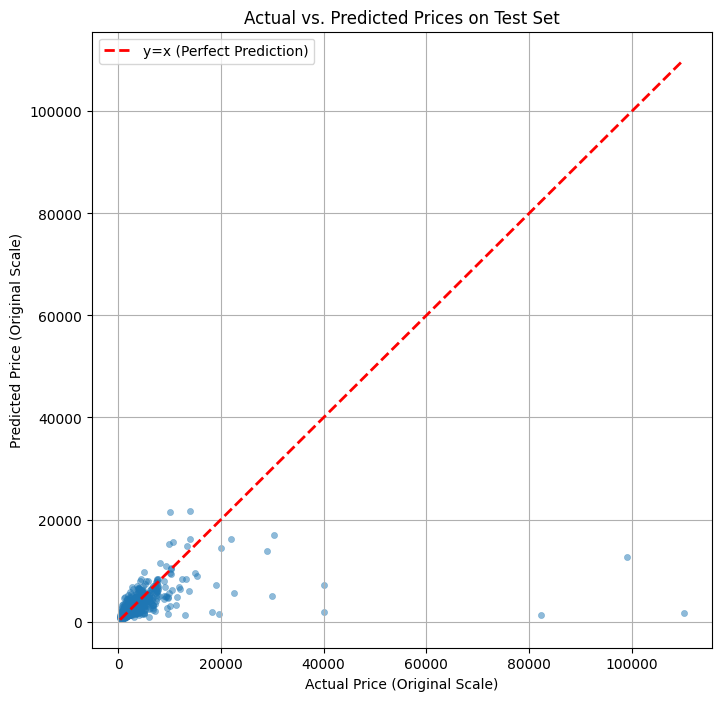

In [37]:
# M5.4b Actual vs. Predicted Plot

# Ensure correct imports are active
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np # Needed for max/min if not already imported
import pandas as pd # Needed for Series quantile if uncommenting limits

if 'y_test_orig' in locals() and 'y_pred_orig' in locals() and y_test_orig is not None and y_pred_orig is not None:
    plt.figure(figsize=(8, 8)) # Uses matplotlib.pyplot
    sns.scatterplot(x=y_test_orig, y=y_pred_orig, alpha=0.5, s=20, edgecolor=None) # Uses seaborn (which uses matplotlib)
    
    # Add y=x line (perfect prediction line)
    # Ensure inputs are numpy arrays or compatible for max/min comparison
    max_val = max(np.max(y_test_orig), np.max(y_pred_orig)) 
    min_val = min(np.min(y_test_orig), np.min(y_pred_orig)) 
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='y=x (Perfect Prediction)')
    
    plt.xlabel("Actual Price (Original Scale)")
    plt.ylabel("Predicted Price (Original Scale)")
    plt.title("Actual vs. Predicted Prices on Test Set")
    plt.legend()
    plt.grid(True)
    
    # Optional: Set limits if outliers dominate too much - use pd.Series for quantile
    # limit_perc = 0.98
    # plt.xlim(min_val, pd.Series(y_test_orig).quantile(limit_perc)) 
    # plt.ylim(min_val, pd.Series(y_pred_orig).quantile(limit_perc))
    
    plt.show() # Display the plot
else:
    print("Error: Original scale test values (y_test_orig, y_pred_orig) not available for plotting.")

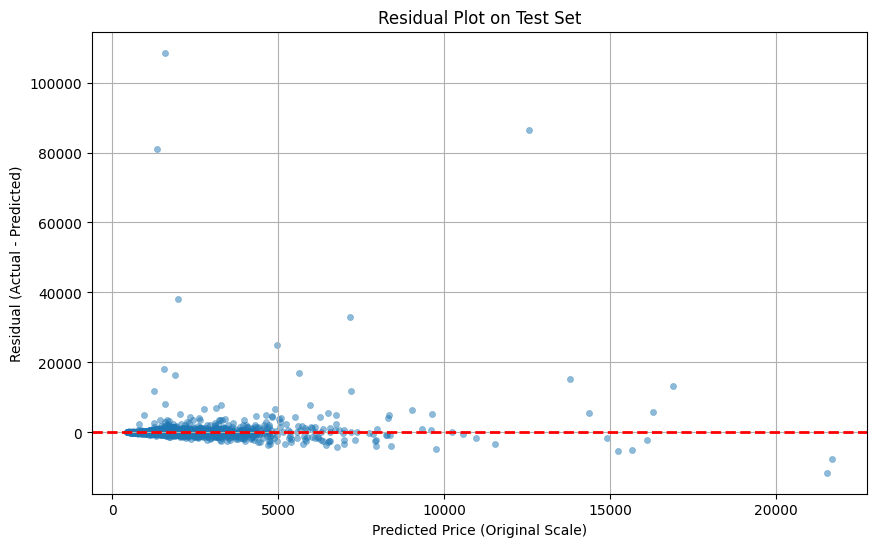


Mean Residual: 320.34


In [38]:
# M5.4c Residual Plot
if 'y_test_orig' in locals() and 'y_pred_orig' in locals() and y_test_orig is not None:
    residuals = y_test_orig - y_pred_orig
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred_orig, y=residuals, alpha=0.5, s=20, edgecolor=None)
    
    # Add horizontal line at y=0 (perfect prediction)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    
    plt.xlabel("Predicted Price (Original Scale)")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title("Residual Plot on Test Set")
    plt.grid(True)
    # Optional: Set limits if outliers dominate y-axis
    # resid_q_low, resid_q_high = residuals.quantile([0.01, 0.99])
    # plt.ylim(resid_q_low, resid_q_high)
    plt.show()
    
    # Optional: Check if mean residual is close to zero
    print(f"\nMean Residual: {residuals.mean():.2f}")

else:
    print("Error: Original scale test values not available for residual plot.")

Calculating feature importances from the final CatBoost model...
Top 30 Features by Importance:


,Feature,Importance
10,availability_30,6.83259
45,bedrooms_log,5.94362
36,days_since_last_review,5.23686
47,accommodates_log,4.89270
11,availability_365,4.14703
35,host_duration_days,3.36165
14,review_scores_rating,3.31302
2,latitude,3.24461
3,longitude,3.17384
22,num_amenities,3.05874


/tmp/ipykernel_1122/901997614.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(30), palette='viridis')


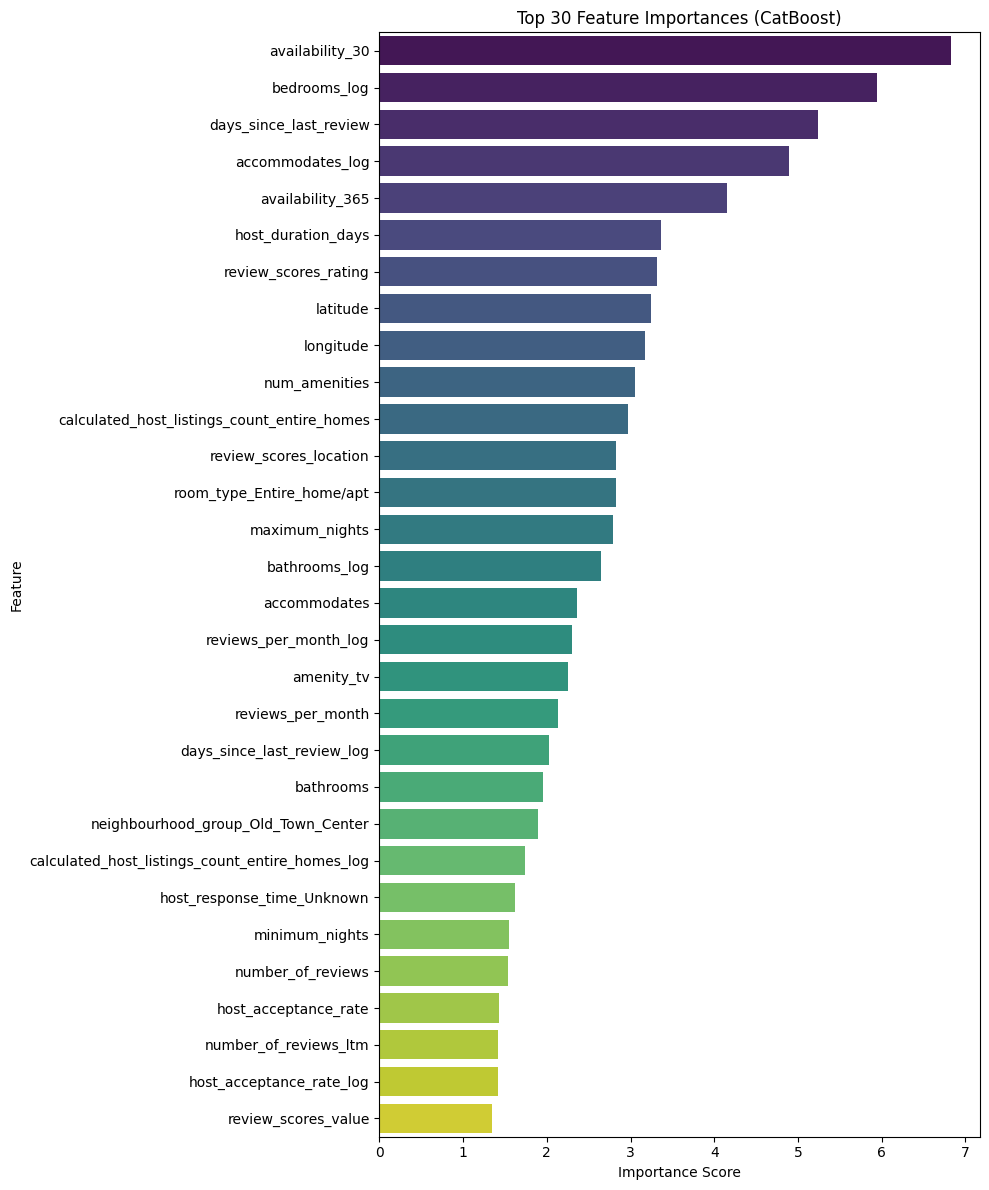

In [39]:
# M5.5 Feature Importance Analysis (using CatBoost built-in)

if 'final_model' in locals() and final_model is not None and hasattr(final_model, 'get_feature_importance') and 'X_train_scaled' in locals():
    print("Calculating feature importances from the final CatBoost model...")
    
    try:
        # Get feature importances (CatBoost often uses prediction value change or similar)
        feature_importances = final_model.get_feature_importance()
        feature_names = X_train_scaled.columns # Get feature names from the scaled training data
        
        # Create a DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

        print(f"Top 30 Features by Importance:")
        display(importance_df.head(30))

        # Plotting feature importances
        plt.figure(figsize=(10, 12)) # Adjust size if needed
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(30), palette='viridis')
        plt.title('Top 30 Feature Importances (CatBoost)')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred calculating/plotting feature importances: {e}")

elif 'final_model' in locals() and final_model is not None and hasattr(final_model, 'feature_importances_'):
    # Fallback for models with .feature_importances_ attribute (like RF, XGB)
    print("Calculating feature importances using .feature_importances_...")
    feature_importances = final_model.feature_importances_
    feature_names = X_train_scaled.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print(f"Top 30 Features by Importance:")
    display(importance_df.head(30))

    # Plotting
    plt.figure(figsize=(10, 12)) 
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(30), palette='viridis')
    plt.title('Top 30 Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

else:
    print("Error: Final model not available or does not support feature importance extraction.")